# Проект Кредитного Скоринга
## Стадия Feature Engineering

Версия 08


Вводные. Задача кредитного скоринга по выявлению дефолтных клиентов.  Необходимо разработать и обучить модель, которая бы выявляла клиентов, которые совершат дефолт. Использовать можно только методы ML. В качестве метрики предложено использовать AUCROC.

Значения столбцов:
- client_id       - идентификатор клиента
- app_date    - дата заявки на кредит
- education       - уровень образования
- sex	            - пол заёмщика
- age	            - возраст заёмщика
- car	            - наличие автомобиля
- car_type        - автомобиль-иномарка
- decline_app_cnt	- количество отказанных прошлых заявок
- good_work       - наличие «хорошей» работы
- score_bki       - скоринговый балл из БКИ
- bki_request_cnt	- количество запросов в БКИ
- region_rating - рейтинг региона
- home_address	- категоризатор домашнего адреса
- work_address	- категоризатор рабочего адреса
- income	        - доход заёмщика
- sna       -   связь заемщика с клиентами банка
- first_time        - давность наличия информации о заемщике
- foreign_passport - наличие загранпаспорта
- default	        - наличие дефолта


Общее замечание.  Работа над задачей носит итеративный характер. В рамках одного ноутбука приходится многократно исполнять одни и те же ячейки без пользы. Принято решение разделить задачу по стадиям:
- Разведывательный анализ данных (EDA)
- Разработка признаков (FE)
- Подбор гиперпараметров (HPT)
- Формирование тестовых данных для соревнований на kaggle (KC).

Первые два шага будут выполнены локально. В облако kaggle будет загружена только последний ноутбук или вообще только конечные данные.

Это **вторая из трех** рабочих книг.

In [59]:
from pandas import Series
import pandas as pd
import pandas_profiling
import numpy as np
from datetime import datetime, date
import time, gc

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from sklearn.feature_selection import f_classif, mutual_info_classif

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, RobustScaler, normalize
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold,  GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import ExtraTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import auc, roc_auc_score, roc_curve, accuracy_score, matthews_corrcoef, precision_score, recall_score, f1_score

import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [60]:
RANDOM_SEED = 42

 ## Вспомогательные функции

In [61]:
def print_metrics(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    cmdf = pd.DataFrame(cm, index = ['actual 0', 'actual 1'], columns = ['detected 0', 'detected 1'])
    print(cmdf)
    g,a,b = g_score(cm)
    print(' ',
        'Accuracy:      {:.4f}'.format(accuracy_score(y_test, y_pred)),
#        'f1_score: {:.4f}'.format(f1_score(y_test, y_pred)),
        'Recall:        {:.4f}'.format(recall_score(y_test, y_pred)),
        'Precision:     {:.4f}'.format(precision_score(y_test,y_pred)),
        'MCC:           {:.4f}'.format(matthews_corrcoef(y_test, y_pred)),
        'AUCROC:        {:.4f}'.format(roc_auc_score(y_test,y_pred)),
        'Detection 0:   {:.4f}'.format(a),
        'Detection 1:   {:.4f}'.format(b),
        'Total G-Score: {:.4f}'.format(g),
        sep="\n")


In [62]:
def init_metrics(name=None):
    lm = ['Recall', 'Selectivity', 'FNR', 'FPR', 'Bal.Error', 'AUCROC', 'f1-score', 'MCC']
    return pd.Series(data=np.zeros(len(lm)),index=lm,name=name, dtype='float64')

In [63]:
def get_metrics(y_test, y_pred, probs, metr ):
    # v = init_metrics(name)
    cm = confusion_matrix(y_test, y_pred)
    TN = cm[0,0]; FP = cm[0,1]; FN = cm[1,0]; TP = cm[1,1]

    # v['Accuracy']=  round(accuracy_score(y_test, y_pred),4)
    metr['Recall'] +=    round(recall_score(y_test, y_pred, zero_division=0),4)
    metr['Selectivity'] += round(( TN/(TN+FP)),4)
    metr['FPR'] += round(( FP/(TN+FP)),4)
    metr['FNR'] += round(( FN/(TP+FN)),4)
    metr['Bal.Error'] += round( ((FN/(TP+FN))+(FP/(TN+FP)))/2 ,4)
    # v['Precision']= round(precision_score(y_test, y_pred, zero_division=0),4)
    metr['f1-score' ] += round(f1_score(y_test, y_pred, zero_division=0),4)
    metr['MCC'] +=       round(matthews_corrcoef(y_test, y_pred),4)
    metr['AUCROC'] +=    round(roc_auc_score(y_test, probs),4)
    return metr

In [64]:
# Evaluate basic model
def eval_basic_models(df, osm='None', list_models=[] ):
    # OSM = oversamplint method
    # train_df = df.drop(['client_id'], axis=1)
    was = time.perf_counter()   # замер времени работы
    _ = gc.collect()            #  принудительный сбор мусора
    X = df.drop(['default'], axis=1).values
    y = df['default'].values

    # RandomOverSampler, SMOTE, ADASYN
    oversamplers = {'RanOS': RandomOverSampler(),'SMOTE': SMOTE(),'ADASYN': ADASYN()}



    # X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.20, random_state=RANDOM_SEED )


    models = {
    # models with default settings
    'LogReg'  : LogisticRegression(max_iter=1000, n_jobs=-1), # fix ConvergenceWarning
    'DecTree' : DecisionTreeClassifier(),
    'ExtTree' : ExtraTreeClassifier(),
    'AdaBst'  : AdaBoostClassifier(n_estimators=100), # количество из демо примера
    'Bagg'    : BaggingClassifier( n_jobs=-1),
    'ExtEns'  : ExtraTreesClassifier(n_jobs =-1),
    'GradBst' : GradientBoostingClassifier(n_estimators=100),  # количество из примера
    'RanFrst' : RandomForestClassifier(n_jobs=-1) }

    if len(list_models) == 0:
        list_models = models.keys()

    metrics = init_metrics('E')   # пустышка для работы concat
    print('Model:', end=' ')

    for mname in list_models:
        # mname = '{}'.format(model).split('(')[0]
        print(mname, end=', ')
        metr=init_metrics(mname)
        #  Набор данных несбалансирован. Поэтому StratifiedKFold
        skf = StratifiedKFold(n_splits=5) # random_state=RANDOM_SEED) - для случая перетасовки
        for train_index, test_index in skf.split(X, y):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
            # Поскольку данные несбалансированные, можем выбрать увеличение количества меньшего класса с помощью
            # того или иного алгоритма
            if osm != 'None':
                sampler = oversamplers[osm]
                X_res, y_res = sampler.fit_resample(X_train, y_train)
            else:
                X_res = X_train; y_res = y_train

            models[mname].fit(X_res, y_res)
            y_pred = models[mname].predict(X_test)
            probs = models[mname].predict_proba(X_test)
            # probs = probs[:,1]
            # zero_division=0 to fix zero division Warning
            # print('Results for:', model)
            metr = get_metrics(y_test, y_pred, probs[:,1], metr )
            # конец цикла кроссвалиадции
        for k in metr.keys():
            metr[k] /= 5  # успеднение накопленных значений метрик
        metrics = pd.concat([metrics, metr], axis=1)
    print('done. {:.4f} sec'.format(time.perf_counter() - was))
    return metrics.drop(['E'],axis=1)

In [65]:
# Построение линейных графиков для сравнения моделей.
# Допустимо несколько линий одновременно
def compare_models_plot(assesment, metrics, tlt):
    cols = assesment.columns
    plt.figure(figsize = (20,5))
    for m in metrics:
        plt.plot(cols, [assesment.loc[m,c] for c in cols], label = m )
    plt.title(tlt, fontsize=14)
    plt.legend(loc='best')
    plt.show();

In [66]:
# Построение графика из столбиков для сравнения моделей.
# Допустима только одна метрика.
def compare_models_bar(assesment, metric, tlt):
    cols = assesment.columns
    plt.figure(figsize = (20,4), frameon=False)
    plt.bar(cols,[assesment.loc[metric,c] for c in cols], width = 0.6)
    plt.title(tlt, fontsize=14)
    plt.show();

In [67]:
# Построение линейных графиков для сравнения всех сценариев обработки и классификации.
# Допустимо только одна метка
def compare_scenarios_plot(assesments, metric, tlt):  #Multiple assesment, single metric
    plt.figure(figsize = (20,5))
    for nm, ast in assesments.items():
        cols = ast.columns
        plt.plot(cols, [ast.loc[metric,c] for c in cols], label = nm )
    plt.title(tlt, fontsize=14)
    plt.legend(loc='best')
    plt.show();

In [68]:
# Построение линейных графиков для сравнения отдельных сценариев.
# Допустимо только одна метка
def compare_some_scenarios_plot(scenarios, assesments, metric, tlt):  #Multiple assesment, single metric
    plt.figure(figsize = (20,5))
    for nm in scenarios:
        ast = assesments[nm]
        cols = ast.columns
        plt.plot(cols, [ast.loc[metric,c] for c in cols], label = nm )
    plt.title(tlt, fontsize=14)
    plt.legend(loc='best')
    plt.show();

In [69]:
# Инициализация вектора инфо о выбросах
def init_surge_info(name=None):
    r = ['Lo otl %', 'Lo outlays', 'Lo hurdle', 'Q1', 'Median', 'Q3', 'Hi hurdle', 'Hi outlays', 'Hi otl %', 'IQR']
    return pd.Series(data=None,index=r,name=name, dtype='float64')

In [70]:
# сбор инфо по выбросам
def collect_surge_info(data, num_cols):
    surge_info = init_surge_info('E')
    total_q = data.shape[0]
    for col in num_cols:
        si = init_surge_info(col)
        si['Median'] = data[col].median()
        si['Q1'] = data[col].quantile(0.25)
        # if np.isnan(si['Q1']):
        #    si['Q1'] = 0
        si['Q3'] = data[col].quantile(0.75)
        # if np.isnan(si['Q3']):
        #    si['Q3'] = 0
        si['IQR'] = si['Q3'] - si['Q1']
        si['Lo hurdle'] = si['Q1'] - 1.5 * si['IQR']
        si['Hi hurdle'] = si['Q3'] + 1.5 * si['IQR']
        si['Lo outlays'] = data.loc[(data[col]<si['Lo hurdle']),col].count()
        si['Lo otl %'] = si['Lo outlays'] / total_q
        si['Hi outlays'] = data.loc[(data[col]>si['Hi hurdle']),col].count()
        si['Hi otl %'] = si['Hi outlays'] / total_q
        # metrics = pd.concat([metrics, m], axis=1)
        surge_info = pd.concat([surge_info,si], axis=1)
        #    if fix :
        # ограничение выдающихся по уровню
        #        data[col] = np.where(data[col] > si['Hi hurdle'], si['Hi hurdle'] , data[col])
        #        data[col] = np.where(data[col] < si['Lo hurdle'], si['Lo hurdle'] , data[col])
    return surge_info.drop(['E'], axis =1)

Функции из стадии  EDA

In [71]:
# обработка даты
def parse_date(data):
    data['app_date'] = data['app_date'].apply(lambda s: datetime.strptime(s,'%d%b%Y').date() )
    min_app_date = data['app_date'].min().toordinal()
    data['app_weekday'] = data['app_date'].apply(lambda d: d.isoweekday())
    data['app_day'] = data['app_date'].apply(lambda d: d.day)
    data['app_month'] = data['app_date'].apply(lambda d: d.month)
    # устранил создание переменной, на более поздних этапах выяснилсь ее незначительность
    # data['app_date_ord'] = data['app_date'].apply(lambda d: d.toordinal()-min_app_date)
    return data

In [72]:
def binarisation_chars(data):
    data['sex'] = data['sex'].apply(lambda x: (1 if x== 'M' else 0))
    data['car'] = data['car'].apply(lambda x: (1 if x== 'Y' else 0))
    data['car_type'] = data['car_type'].apply(lambda x: (1 if x== 'Y' else 0))
    data['foreign_passport'] = data['foreign_passport'].apply(lambda x: (1 if x== 'Y' else 0))
    # data.head()
    return data

In [73]:
def categorisation_education(data):
    # filling missing values
    edu_vals = data['education'].value_counts()
    # edu_vals
    data['education'].fillna(value=edu_vals.index[0], inplace=True)
    # translating str education to num categories
    edu_cat = {'UGR': 2, 'SCH': 1, 'GRD': 3, 'PGR': 4, 'ACD': 5}  #полагаю, что ugr = неоконченное высшее
    data['educ_cat'] = data['education'].apply(lambda x: edu_cat[x])
    # data.head(3)
    return data

In [74]:
def region_clean(data):
    # сжатие рейтинга региона до одной десятичной цифры
    data['reg_rate'] = np.rint(data['region_rating'] / 10).astype(int)
    data = data.drop(['region_rating'], axis=1)
    return data

Функции стадии FE


In [75]:
def feat_eng_01(data):
    # все пороги по результатам стадии EDA !!!
    data['age_grade'] = data['age'].apply(
        lambda a: 0 if a < 30 else (1 if a < 40 else (2 if a < 50 else (3 if a < 60 else 4))))
    data['bki_request_cnt'] = data['bki_request_cnt'].apply(lambda x: x if x < 10 else 10)
    data['decline_app_cnt'] = data['decline_app_cnt'].apply(lambda x: x if x < 5 else 5)
    data['log_income'] = np.log1p(data['income'])
    data['log_income'] = data['log_income'].apply(lambda x: 8.6 if x < 8.6 else (x if x < 12.1 else 12.1))
    # data['log_income_norm'] = np.linalg.norm(data['log_income'])  не работает !!
    i_mu = data['log_income'].mean()
    i_std = data['log_income'].std()
    # print(i_mu, i_std)
    data['log_income_norm'] = data['log_income'].apply(lambda x: (x - i_mu) / i_std)
    data['score_bki'] = data['score_bki'].apply(lambda x: -3.3 if x < -3.3 else (x if x < -0.5 else - 0.5))
    # data['score_bki_norm'] = np.linalg.norm(data['score_bki'])
    s_mu = data['score_bki'].mean()
    s_std = data['score_bki'].std()
    # print(s_mu, s_std)
    data['score_bki_norm'] = data['score_bki'].apply(lambda x: (x - s_mu) / s_std)

    # data = data.drop(['app_date_ord'],axis=1)
    return data

In [76]:
def feat_eng_02(data):
    # car и car type
    data['car_cat'] = data.apply(lambda s: s['car'] + s['car_type'], axis=1)
    data = data.drop(['car', 'car_type'], axis=1)
    # расстояние между адресами
    data['address_distance'] = data.apply(lambda s: np.absolute(s['home_address'] - s['work_address']), axis=1)
    data = data.drop(['home_address'], axis=1)
    data['sna_fist_distance'] = data.apply(lambda s: np.absolute(s['sna'] - s['first_time']), axis=1)
    # показатель имеет слишком высокую корреляцию с good work
    # data['transpar'] = data.apply(lambda s: s['foreign_passport'] + s['good_work'] + s['good_work'], axis=1)
    # data = data.drop(['good_work'],axis =1 )  # принял решение убрать goodwork
    return data

In [77]:
def feat_eng_03(data):
    # Функция результат двух итераций - сначала реализовал(добавил) привлекательыне идеи признаков а потом убрал высокую корреляцию
    # data = mean_rel_cols(data,'age_grade','log_income_norm','mean_loginc_age', 'rel_loginc_age') # средний и относит доход по возрастным группам
    data['mean_loginc_age'] = data['age_grade'].map(data.groupby('age_grade')['log_income_norm'].mean().to_dict())
    # data = mean_rel_cols(data,'age_grade','score_bki_norm','mean_scr_bki_age', 'rel_scr_bki_age')  # средний и относит скоринг БКИ по возрастным группам
    # оставляем log_income_norm, score_bki по региону reg_rate
    # data = mean_rel_cols(data, 'reg_rate', 'log_income_norm', 'mean_loginc_reg', 'rel_loginc_reg') # среднее и относит доход по регионам
    # data = mean_rel_cols(data, 'reg_rate', 'score_bki_norm', 'mean_scr_bki_reg', 'rel_scr_bki_reg') # среднее и относит доход по регионам
    data['mean_scr_bki_reg'] = data['reg_rate'].map(data.groupby('reg_rate')['score_bki_norm'].mean().to_dict())
    # оставляем log_income_norm, score_bki_norm, sna(?) по educ_cat
    # data = mean_rel_cols(data, 'educ_cat', 'log_income_norm', 'mean_loginc_edu', 'rel_loginc_edu') # среднее и относит доход по образованию
    # data = mean_rel_cols(data, 'educ_cat', 'score_bki_norm', 'mean_scr_bki_edu', 'rel_scr_bki_edu') # среднее и относит доход по образованию
    data['mean_scr_bki_edu'] = data['educ_cat'].map(data.groupby('educ_cat')['score_bki_norm'].mean().to_dict())
    return data

In [78]:
# show features with corr > 0.85
def show_high_corr_features(data, m_cols, hurdle=0.85):
    corr = data[m_cols].corr().abs()
    corr_table = corr.unstack()
    corr_table_sorted = corr_table.sort_values(kind="quicksort", ascending=False)
    corr_exclude_ones = corr_table_sorted[corr_table_sorted != 1]
    return corr_exclude_ones[corr_exclude_ones >= hurdle]


In [79]:
def show_min_important_features(data, model_cols, target_col, hurdle=0.0001):
    imp_cat = Series(mutual_info_classif(data[model_cols], data[target_col]), index=model_cols)
    imp_cat.sort_values(inplace=True)
    return imp_cat[imp_cat < hurdle]

Функции проверке гипотезы о пороге и сбалансированности выборки

In [80]:
def calc_probs(df, oversample=False):
    was = time.perf_counter()  # замер времени работы
    X = df.drop(['default'], axis=1).values
    y = df['default'].values
    model = LogisticRegression(max_iter=1000, n_jobs=-1)
    # probs_arr = dict()
    step = 0
    skf = StratifiedKFold(n_splits=5)  # random_state=RANDOM_SEED) - для случая перетасовки
    oversampler = RandomOverSampler()
    for train_index, test_index in skf.split(X, y):
        print(step, end='')
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        if oversample:
            X_res, y_res = oversampler.fit_resample(X_train, y_train)
        else:
            X_res = X_train;
            y_res = y_train
        # print('s',end='')
        model.fit(X_res, y_res)
        #print('f',end='')
        y_pred = model.predict(X_test)
        y_probs = model.predict_proba(X_test)
        # probs_arr[0] = y_probs[:,1]
        #`df = pd.DataFrame({'col1': [1, 2], 'col2': [3, 4]})`
        curr_calc = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred, 'y_prob': y_probs[:, 1]})
        #print('d',end='')
        #print(curr_calc.head())
        if step > 0:
            all_calc = pd.concat([all_calc, curr_calc])
        else:
            all_calc = curr_calc.copy(deep=True)
        # print(step,end='')
        step += 1
    print(' done. {:.4f} sec'.format(time.perf_counter() - was))
    return all_calc

In [81]:
# Формирование таблицы метрик из набора вероятностных значений
def calc_metrics(prob_data, start=5, end=86):
    smth = DataFrame()
    for l in range(start, end):
        hurdle = l / 100.
        y_test = prob_data['y_test']
        y_pred = prob_data['y_prob'].apply(lambda x: 0 if x < hurdle else 1)
        cm = confusion_matrix(y_test, y_pred)
        TN = cm[0, 0];
        FP = cm[0, 1];
        FN = cm[1, 0];
        TP = cm[1, 1]
        d = {'lvl': hurdle,
             'Recall': round(recall_score(y_test, y_pred, zero_division=0), 4),
             'Selectivity': round((TN / (TN + FP)), 4),
             'FPR': round((FP / (TN + FP)), 4),
             'FNR': round((FN / (TP + FN)), 4),
             'Bal.Error': round(((FN / (TP + FN)) + (FP / (TN + FP))) / 2, 4),
             'f1-score': round(f1_score(y_test, y_pred, zero_division=0), 4),
             'MCC': round(matthews_corrcoef(y_test, y_pred), 4)}
        smth = smth.append(pd.DataFrame(d, [l]), ignore_index=True)
    return smth

 ## Подготовка данных по итогам предыдущей стадии

In [82]:
data = pd.read_csv('train.csv')
data.shape

(73799, 19)

In [83]:
data.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0
3,16222,23JAN2014,SCH,F,53,N,N,0,0,-2.057471,2,50,2,3,10000,1,3,N,0
4,101655,18APR2014,GRD,M,48,N,N,0,1,-1.244723,1,60,2,3,30000,1,4,Y,0


In [84]:
classes=data['default'].value_counts()
print('Class 0: {} items,'.format(classes[0]), 'Class 1: {} items,'.format(classes[1]),  'Ratio {:.2f}:1'.format(classes[0]/classes[1]))

Class 0: 64427 items, Class 1: 9372 items, Ratio 6.87:1


In [85]:
data = parse_date(data)

In [86]:
data = binarisation_chars(data)
data = categorisation_education(data)
data = region_clean(data)
data.columns

Index(['client_id', 'app_date', 'education', 'sex', 'age', 'car', 'car_type',
       'decline_app_cnt', 'good_work', 'score_bki', 'bki_request_cnt',
       'home_address', 'work_address', 'income', 'sna', 'first_time',
       'foreign_passport', 'default', 'app_weekday', 'app_day', 'app_month',
       'educ_cat', 'reg_rate'],
      dtype='object')

In [87]:
data.head()
# сохраняю данные после преобразований для дальнейшего использования
# data.to_csv('Scoring05.csv')

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,...,income,sna,first_time,foreign_passport,default,app_weekday,app_day,app_month,educ_cat,reg_rate
0,25905,2014-02-01,SCH,1,62,1,1,0,0,-2.008753,...,18000,4,1,0,0,6,1,2,1,5
1,63161,2014-03-12,SCH,0,59,0,0,0,0,-1.532276,...,19000,4,1,0,0,3,12,3,1,5
2,25887,2014-02-01,SCH,1,25,1,0,2,0,-1.408142,...,30000,1,4,1,0,6,1,2,1,8
3,16222,2014-01-23,SCH,0,53,0,0,0,0,-2.057471,...,10000,1,3,0,0,4,23,1,1,5
4,101655,2014-04-18,GRD,1,48,0,0,0,1,-1.244723,...,30000,1,4,1,0,5,18,4,3,6


## Формирование базы для сравнения

По результатам сравнения по итогам стадии EDA сформирован короткий список из четырех моделей - LinearRegresstion, Decision Tree и два ансамбля - Ada и Gradient бустинги.  Также имеет смысл ограничиться только одним алгоритмом балансировки набора данных - использовать Random Oversampling.

Сформируем начальную точку отсчета для сравнения этапов.


Model: LogReg, DecTree, AdaBst, GradBst, done. 89.9877 sec
Model: LogReg, DecTree, AdaBst, GradBst, done. 132.1241 sec


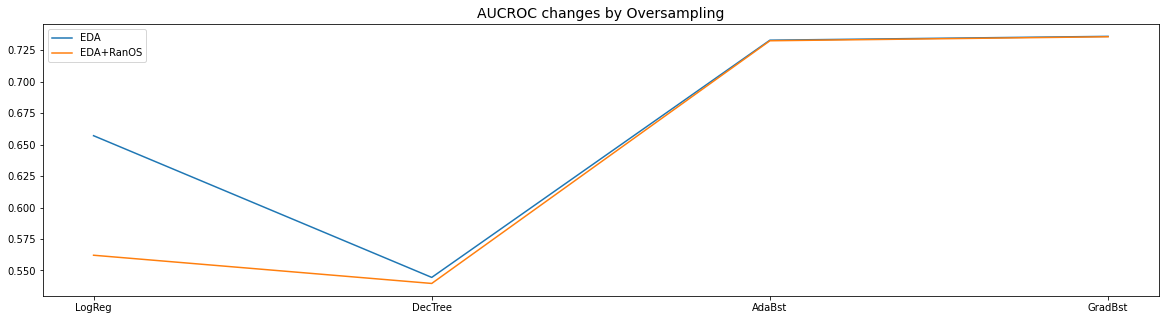

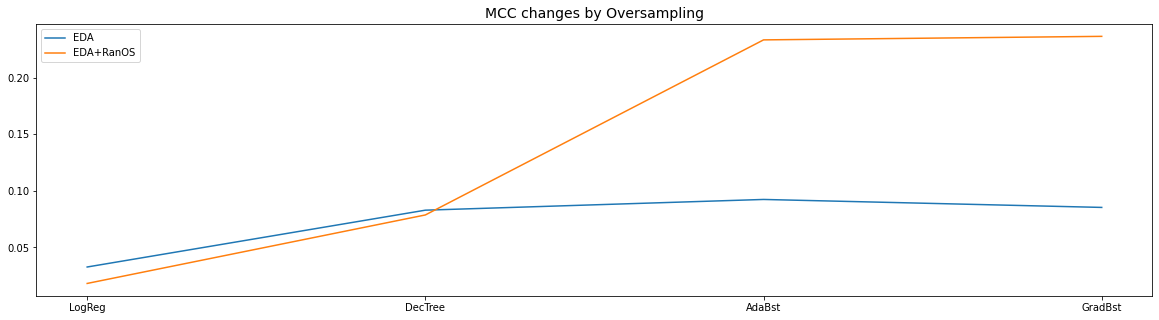

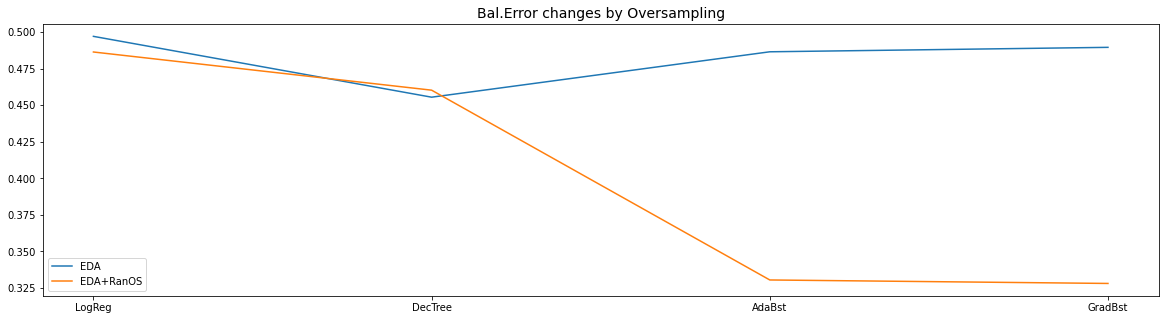

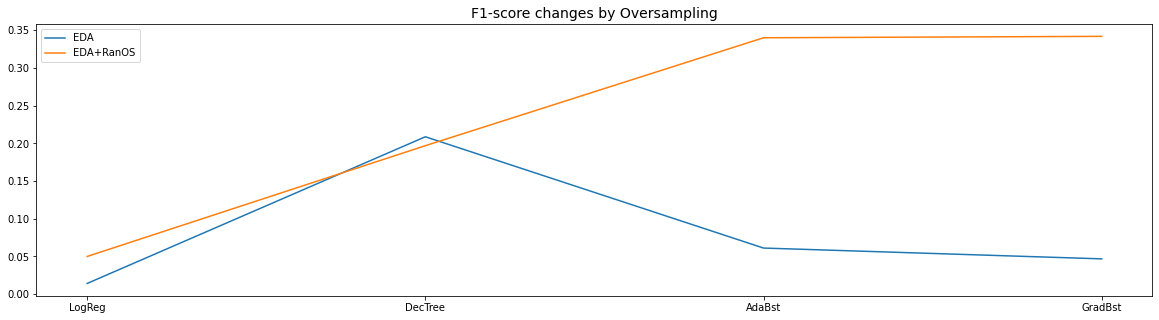

In [88]:
short_mod_list = [ 'LogReg', 'DecTree', 'AdaBst', 'GradBst']
fe_eval =  dict()
fe_eval['EDA'] = eval_basic_models(data.drop(['client_id', 'app_date', 'education'],axis=1), 'None', short_mod_list )
fe_eval['EDA+RanOS'] = eval_basic_models(data.drop(['client_id', 'app_date', 'education'],axis=1), 'RanOS', short_mod_list )
compare_scenarios_plot(fe_eval,'AUCROC','AUCROC changes by Oversampling')
compare_scenarios_plot(fe_eval,'MCC','MCC changes by Oversampling')
compare_scenarios_plot(fe_eval,'Bal.Error','Bal.Error changes by Oversampling')
compare_scenarios_plot(fe_eval,'f1-score','F1-score changes by Oversampling')


## Feature Engineering




### Идеи для разработки признаков

Группа FE01
- score_bki - ограничить выбросы и нормализовать
- income - логарифмировать, ограничить выбросы и нормализовать (или отбросить)
- ограничить decline_app_cnt
- ограничить bki_req_cnt
- выбросить дату подачи заявки (от начала наблюдений)
- преобразовать age в категориальную переменную - до 30, 30..40, 40..50, 50..60, 60..



Группа FE02
- объединить car и car type
- ввести расстояние между двумя адресами
- ввести расстояние между sna и first time
- возможно ввести показатели среднего количества запросов БКИ и отклоненных заявок по возрастным группам
- возможно категоризировать количество запросов БКИ и отклоненных заявок



### FE01: Разработка количественных признаков

Идеи развития признаков:
- score_bki - ограничить выбросы и нормализовать
- income - логарифмировать, ограничить выбросы и нормализовать (или отбросить)
- ограничить decline_app_cnt на уровне 5
- ограничить bki_req_cnt на уровне 10
- выбросить дату подачи заявки (от начала наблюдений)
- преобразовать количественную переменную age в категориальную - до 30, 30..40, 40..50, 50..60, 60..


In [89]:
data = feat_eng_01(data)
data.columns

Index(['client_id', 'app_date', 'education', 'sex', 'age', 'car', 'car_type',
       'decline_app_cnt', 'good_work', 'score_bki', 'bki_request_cnt',
       'home_address', 'work_address', 'income', 'sna', 'first_time',
       'foreign_passport', 'default', 'app_weekday', 'app_day', 'app_month',
       'educ_cat', 'reg_rate', 'age_grade', 'log_income', 'log_income_norm',
       'score_bki_norm'],
      dtype='object')

In [90]:
data.head(5)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,...,default,app_weekday,app_day,app_month,educ_cat,reg_rate,age_grade,log_income,log_income_norm,score_bki_norm
0,25905,2014-02-01,SCH,1,62,1,1,0,0,-2.008753,...,0,6,1,2,1,5,4,9.798183,-0.803865,-0.208633
1,63161,2014-03-12,SCH,0,59,0,0,0,0,-1.532276,...,0,3,12,3,1,5,3,9.852247,-0.723698,0.751196
2,25887,2014-02-01,SCH,1,25,1,0,2,0,-1.408142,...,0,6,1,2,1,8,0,10.308986,-0.046444,1.001255
3,16222,2014-01-23,SCH,0,53,0,0,0,0,-2.057471,...,0,4,23,1,1,5,3,9.210440,-1.675371,-0.306773
4,101655,2014-04-18,GRD,1,48,0,0,0,1,-1.244723,...,0,5,18,4,3,6,2,10.308986,-0.046444,1.330452


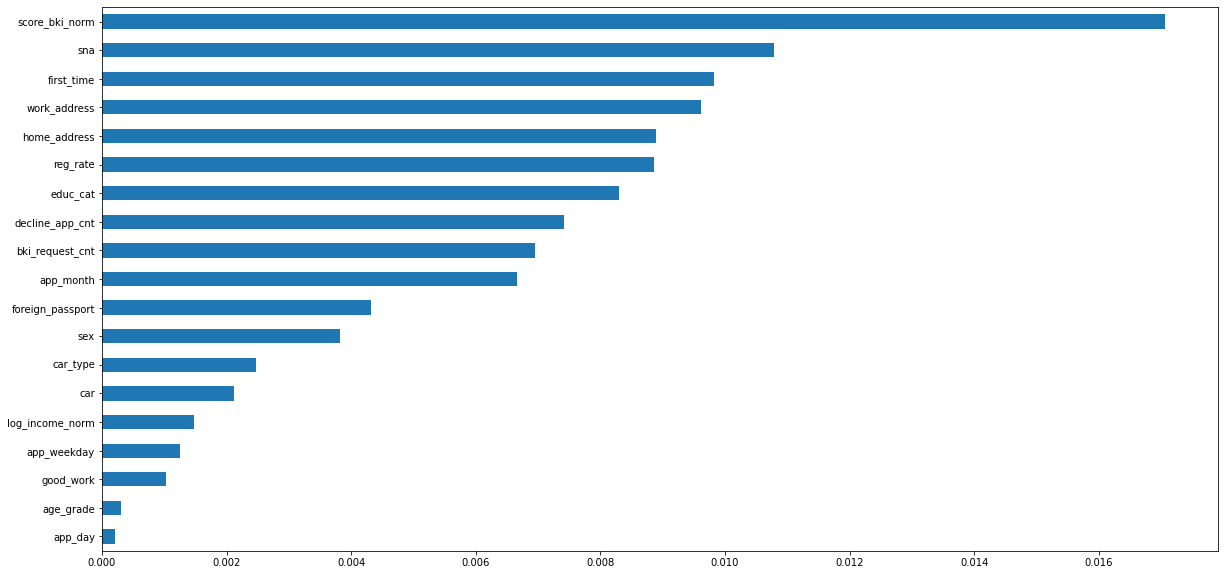

In [91]:
model_cols = ['sex',  'car', 'car_type', 'decline_app_cnt', 'good_work',  'bki_request_cnt', 'home_address', 'work_address', 'sna', 'first_time',   'foreign_passport', 'app_weekday', 'app_day', 'app_month', 'educ_cat', 'reg_rate', 'age_grade', 'log_income_norm', 'score_bki_norm']
plt.figure(figsize=(20, 10))
imp_cat = Series(mutual_info_classif(data[model_cols], data['default']), index = model_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh');


Нормализованный логарифм дохода и грейдированный возраст подросли в уровне важности для предсказания.  На следующий день грейдированный возраст провалился в уровне значимости из-за инициализации другим случайным числом.

In [92]:
# data[model_cols].info()

Model: LogReg, DecTree, AdaBst, GradBst, done. 142.2474 sec


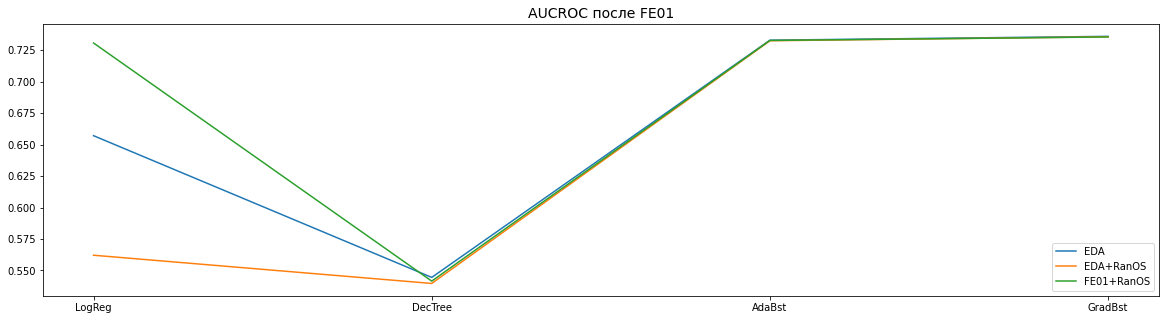

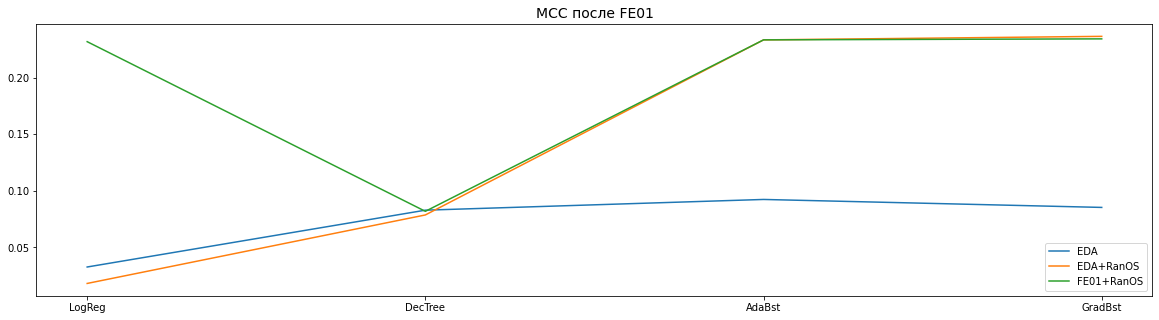

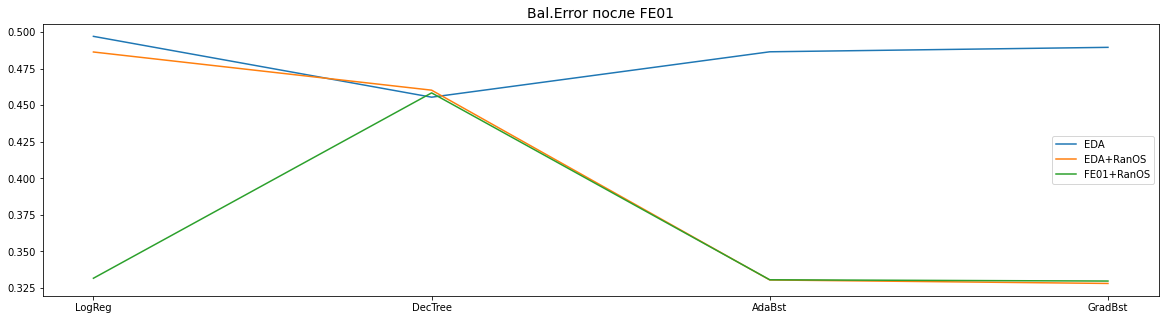

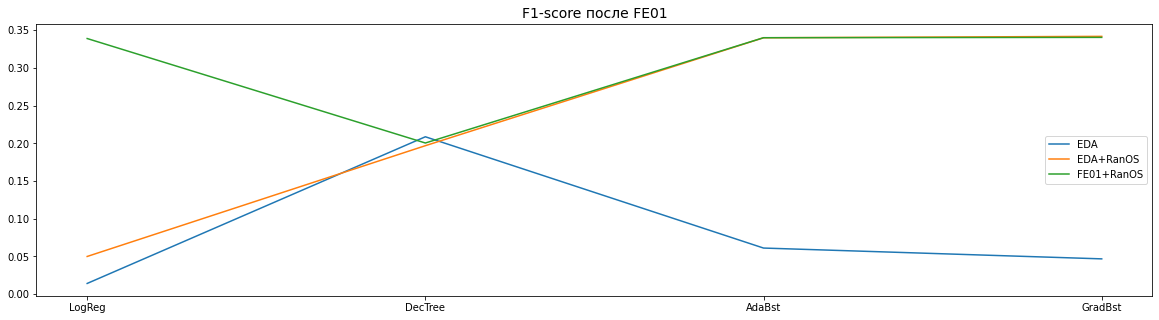

In [93]:
model_cols = model_cols + ['default']
# fe_eval['FE01'] = eval_basic_models(data[model_cols], 'None', short_mod_list )
fe_eval['FE01+RanOS'] = eval_basic_models(data[model_cols], 'RanOS', short_mod_list )
compare_scenarios_plot(fe_eval,'AUCROC','AUCROC после FE01')
compare_scenarios_plot(fe_eval,'MCC','MCC после FE01')
compare_scenarios_plot(fe_eval,'Bal.Error','Bal.Error после FE01')
compare_scenarios_plot(fe_eval,'f1-score','F1-score после FE01')


Стадия разработки признаков FE нанесла существенную пользу качеству моделей. При этом логистическая регрессия при обучении со случайным добором младшего класса неожиданно хорошо выглядит на фоне двух сложных ансамблей.

#### Идеи развития признаков:

Группа FE02:
- объединить car и car type в car_cat
- ввести расстояние между двумя адресами
- ввести расстояние между sna и first time
- ввести синтетический признак foreign_passport + 2 * good_work - получится категорийный с 4мя значениями

Группа FE03:
- ввести показатели средних log_income_norm, bki_req_cnt, decline_app_cnt, score_bki_norm по возрастным группам
- ввести показатели отклонения актуального значения log_income_norm, bki_req_cnt, decline_app_cnt, score_bki_norm от среднего по возрастной группе
- ввести показатели среднего образования, адресов, типа автомобиля, sna, first_time (округление до целого) по возрастной группе и отличия актуального значения от среднего по группе
- вероятно средние значения показателей будут справочными, а в модели будут нужны отклонения от среднего
- посмотреть на распределение наличия загран паспорта по возрвстным группам (округленные до целого значения), если отлично от нуля - вести показатели среднего значения наличия загранпаспорта и отклонения от среднего (-1 - хуже среднего, 0 - норма, +1 лучше среднего)

Идеи для FE04
- аналогичное среднее по региону и отклонение от среднего по региону

Идея для FEO5 - преобразование категорийных признаков в индексные наборы
- сделать взаимодействие индексных наборов и количественных признаков (умножение одного на другое)

Последующие стадии разработки признаков показали существенную корреляционную зависимость признаков со старыми признаками и между собой. Многие варианты были исключены.

### FE02 - разработка категориальных признаков

Группа FE02:
- объединить car и car type в car_cat
- ввести расстояние между двумя адресами
- ввести расстояние между sna и first time


In [94]:
data = feat_eng_02(data)
data.columns

Index(['client_id', 'app_date', 'education', 'sex', 'age', 'decline_app_cnt',
       'good_work', 'score_bki', 'bki_request_cnt', 'work_address', 'income',
       'sna', 'first_time', 'foreign_passport', 'default', 'app_weekday',
       'app_day', 'app_month', 'educ_cat', 'reg_rate', 'age_grade',
       'log_income', 'log_income_norm', 'score_bki_norm', 'car_cat',
       'address_distance', 'sna_fist_distance'],
      dtype='object')

In [95]:
data.head(5)

,client_id,app_date,education,sex,age,decline_app_cnt,good_work,score_bki,bki_request_cnt,work_address,...,app_month,educ_cat,reg_rate,age_grade,log_income,log_income_norm,score_bki_norm,car_cat,address_distance,sna_fist_distance
0,25905,2014-02-01,SCH,1,62,0,0,-2.008753,1,2,...,2,1,5,4,9.798183,-0.803865,-0.208633,2,1,3
1,63161,2014-03-12,SCH,0,59,0,0,-1.532276,3,3,...,3,1,5,3,9.852247,-0.723698,0.751196,0,1,3
2,25887,2014-02-01,SCH,1,25,2,0,-1.408142,1,2,...,2,1,8,0,10.308986,-0.046444,1.001255,1,1,3
3,16222,2014-01-23,SCH,0,53,0,0,-2.057471,2,3,...,1,1,5,3,9.210440,-1.675371,-0.306773,0,1,2
4,101655,2014-04-18,GRD,1,48,0,1,-1.244723,1,3,...,4,3,6,2,10.308986,-0.046444,1.330452,0,1,3


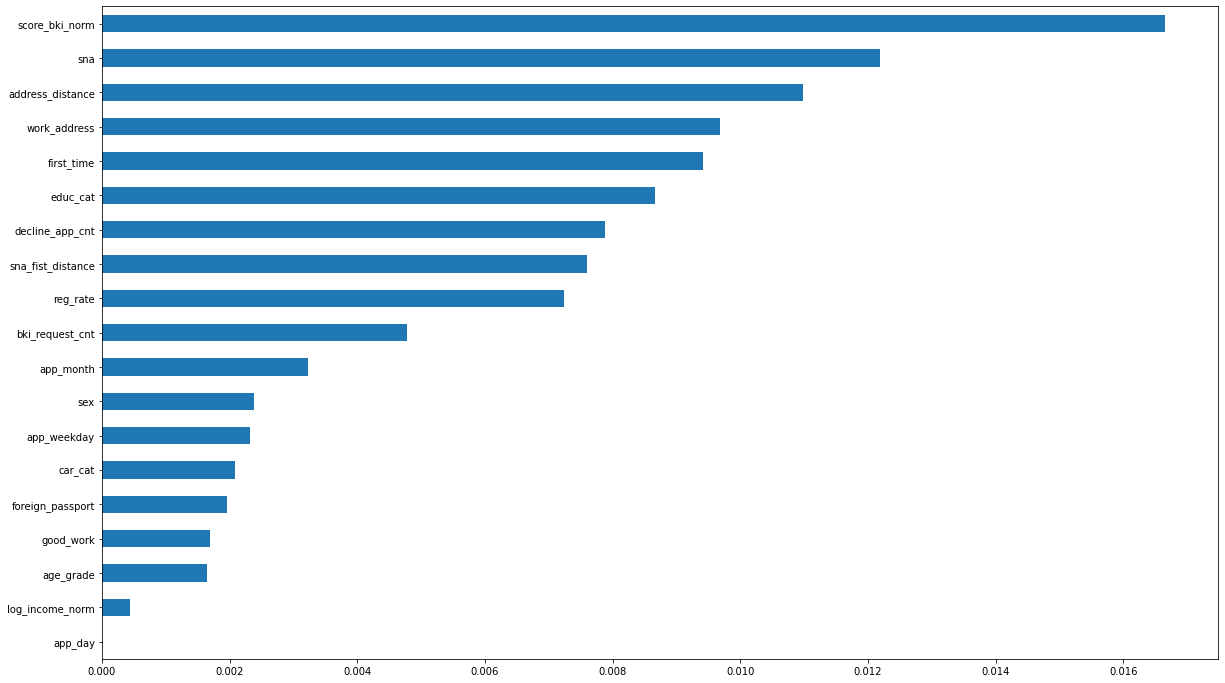

In [96]:
model_cols = ['sex', 'decline_app_cnt', 'good_work', 'bki_request_cnt', 'work_address', 'sna', 'first_time',   'foreign_passport', 'app_weekday', 'app_day', 'app_month', 'educ_cat', 'reg_rate', 'age_grade', 'log_income_norm', 'score_bki_norm', 'car_cat', 'address_distance', 'sna_fist_distance']
plt.figure(figsize=(20, 12))
imp_cat = Series(mutual_info_classif(data[model_cols], data['default']), index = model_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh');


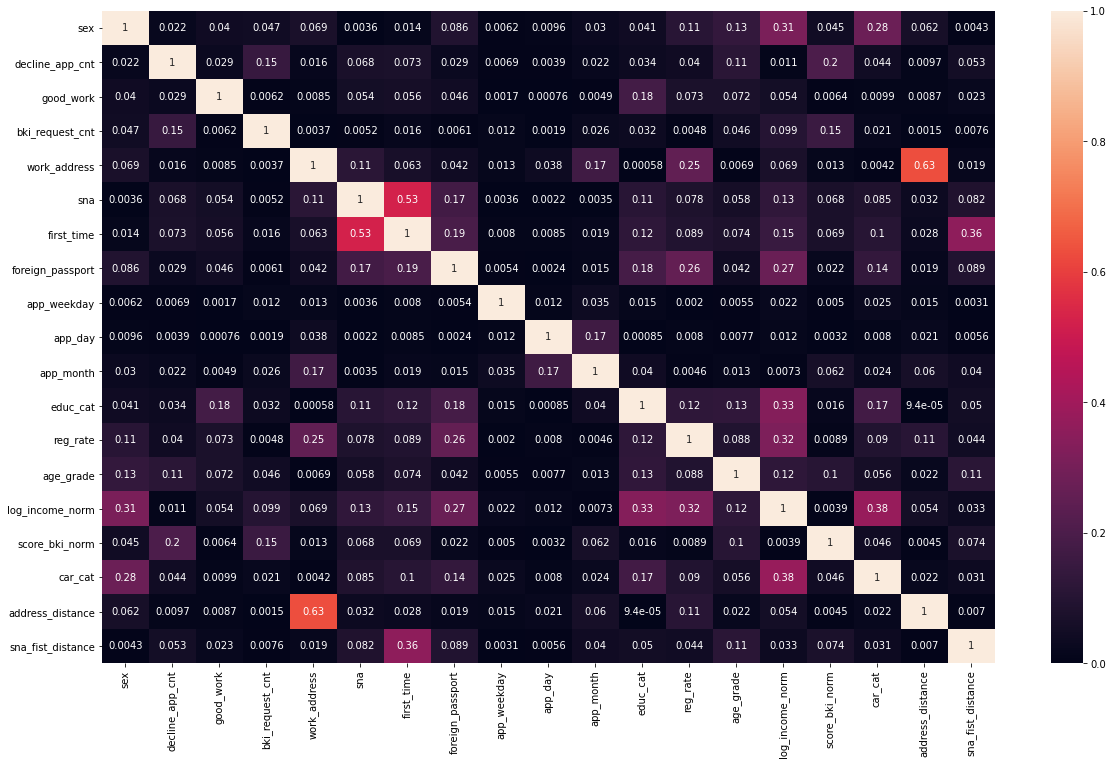

In [97]:
plt.figure(figsize=(20, 12))
sns.heatmap(data[model_cols].corr().abs(), vmin=0, vmax=1, annot = True);

In [98]:
show_high_corr_features(data,model_cols)

Series([], dtype: float64)

По результатам корр.анализа наблюдается заметная корреляция work_address и address_distance.

Model: LogReg, DecTree, AdaBst, GradBst, done. 142.9648 sec


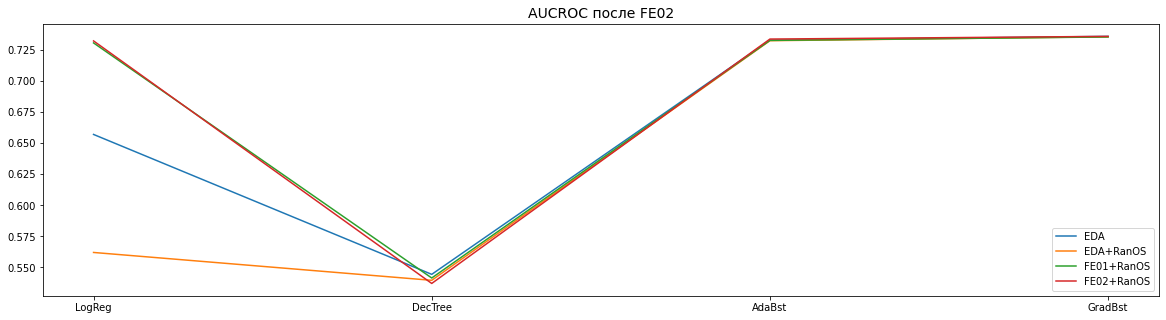

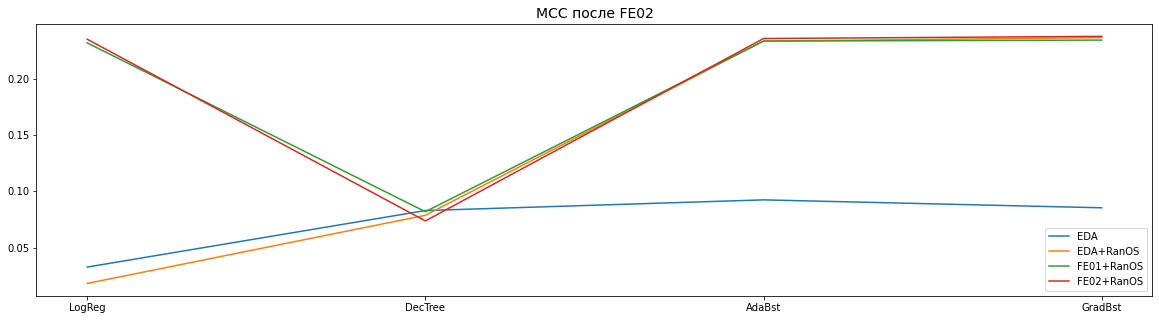

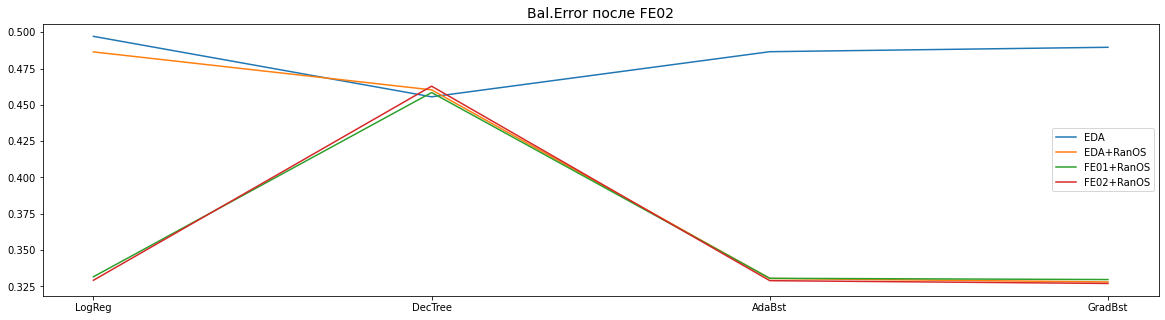

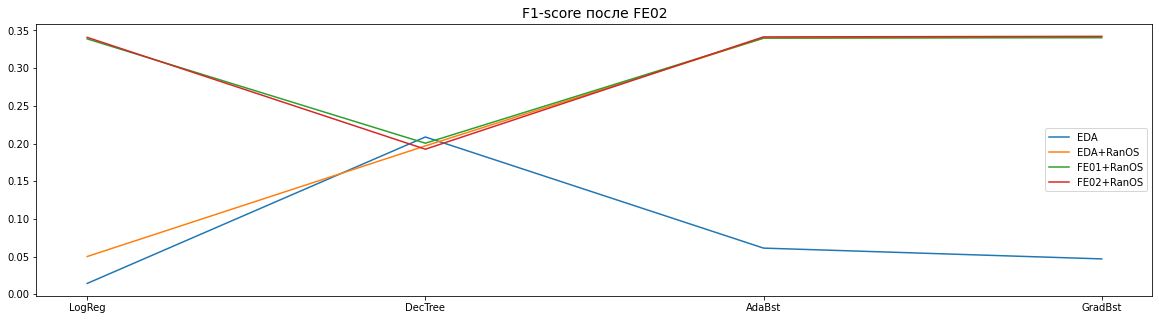

In [99]:
model_cols = model_cols + ['default']
# fe_eval['FE02'] = eval_basic_models(data[model_cols], 'None', short_mod_list )
fe_eval['FE02+RanOS'] = eval_basic_models(data[model_cols], 'RanOS', short_mod_list )
compare_scenarios_plot(fe_eval,'AUCROC','AUCROC после FE02')
compare_scenarios_plot(fe_eval,'MCC','MCC после FE02')
compare_scenarios_plot(fe_eval,'Bal.Error','Bal.Error после FE02')
compare_scenarios_plot(fe_eval,'f1-score','F1-score после FE02')

Эффект стадии FE02 не очень заметен.  Отрицательного эффекта нет.

### FE03: Разработка признаков вокруг категорий

- ввести показатели средних log_income_norm, bki_req_cnt, score_bki_norm по возрастным группам
- ввести показатели отклонения актуального значения log_income_norm, bki_req_cnt, decline_app_cnt, score_bki_norm от среднего по возрастной группе
- ввести показатели среднего образования, адресов, типа автомобиля, sna, first_time (округление до целого) по возрастной группе и отличия актуального значения от среднего по группе
- На практие заметны различия по доходу и скорингу БКИ. Остальное чаще практически не меняется, хотя я не придумал как представлять взаимодействие sna и educ_cat.
- Вероятно средние значения показателей будут справочными, а в модели будут нужны отклонения от среднего



In [100]:
data = feat_eng_03(data)
data.columns


Index(['client_id', 'app_date', 'education', 'sex', 'age', 'decline_app_cnt',
       'good_work', 'score_bki', 'bki_request_cnt', 'work_address', 'income',
       'sna', 'first_time', 'foreign_passport', 'default', 'app_weekday',
       'app_day', 'app_month', 'educ_cat', 'reg_rate', 'age_grade',
       'log_income', 'log_income_norm', 'score_bki_norm', 'car_cat',
       'address_distance', 'sna_fist_distance', 'mean_loginc_age',
       'mean_scr_bki_reg', 'mean_scr_bki_edu'],
      dtype='object')

In [101]:
data.head()

,client_id,app_date,education,sex,age,decline_app_cnt,good_work,score_bki,bki_request_cnt,work_address,...,age_grade,log_income,log_income_norm,score_bki_norm,car_cat,address_distance,sna_fist_distance,mean_loginc_age,mean_scr_bki_reg,mean_scr_bki_edu
0,25905,2014-02-01,SCH,1,62,0,0,-2.008753,1,2,...,4,9.798183,-0.803865,-0.208633,2,1,3,-0.683504,-0.021792,-0.001431
1,63161,2014-03-12,SCH,0,59,0,0,-1.532276,3,3,...,3,9.852247,-0.723698,0.751196,0,1,3,-0.177037,-0.021792,-0.001431
2,25887,2014-02-01,SCH,1,25,2,0,-1.408142,1,2,...,0,10.308986,-0.046444,1.001255,1,1,3,-0.017150,0.005659,-0.001431
3,16222,2014-01-23,SCH,0,53,0,0,-2.057471,2,3,...,3,9.210440,-1.675371,-0.306773,0,1,2,-0.177037,-0.021792,-0.001431
4,101655,2014-04-18,GRD,1,48,0,1,-1.244723,1,3,...,2,10.308986,-0.046444,1.330452,0,1,3,0.121598,-0.019324,-0.029306


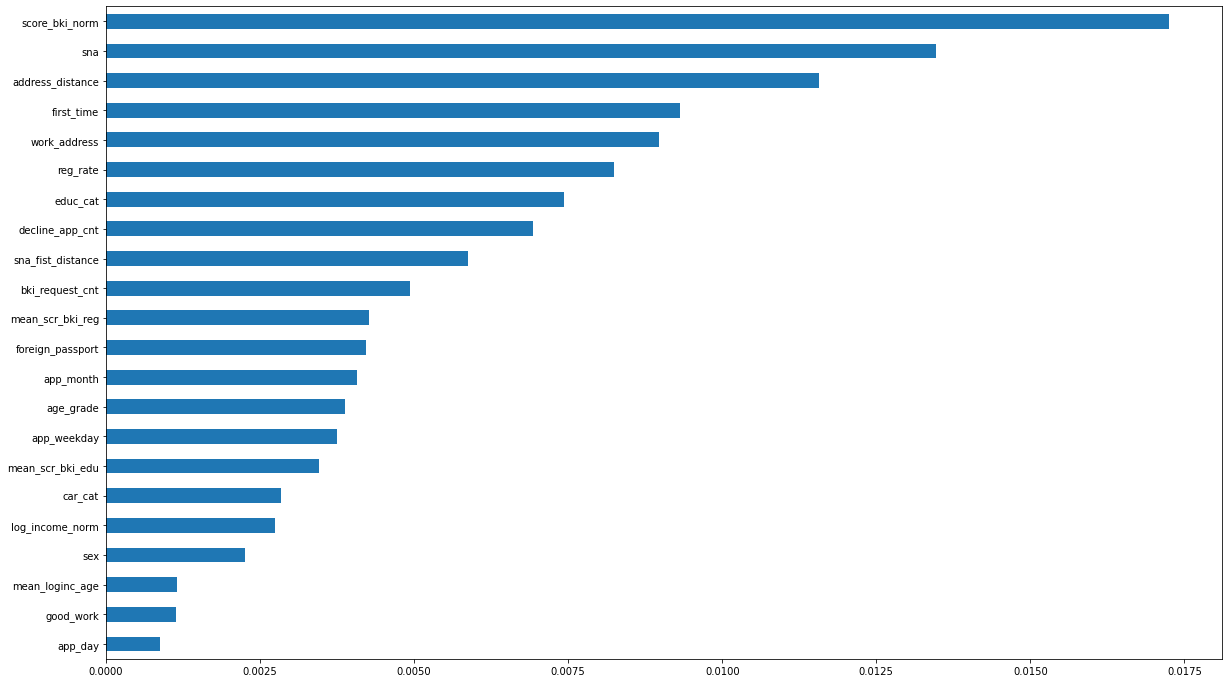

In [102]:
model_cols = ['sex', 'decline_app_cnt', 'good_work', 'bki_request_cnt', 'work_address', 'sna',
              'first_time', 'foreign_passport', 'app_weekday', 'app_day', 'app_month', 'educ_cat', 'reg_rate',
              'age_grade', 'log_income_norm', 'score_bki_norm', 'car_cat', 'address_distance', 'sna_fist_distance',
               'mean_loginc_age', 'mean_scr_bki_reg', 'mean_scr_bki_edu']
plt.figure(figsize=(20, 12))
imp_cat = Series(mutual_info_classif(data[model_cols], data['default']), index=model_cols)
imp_cat.sort_values(inplace=True)
imp_cat.plot(kind='barh');

Средний скоринг по bki по возрасту и средний доход по возрасту оказались не очень существенными. Значит при определении ценности признака в ходе взаимных перестановок нарушаются какие-то пока не выясненные взаимосвязи исходных признаков.

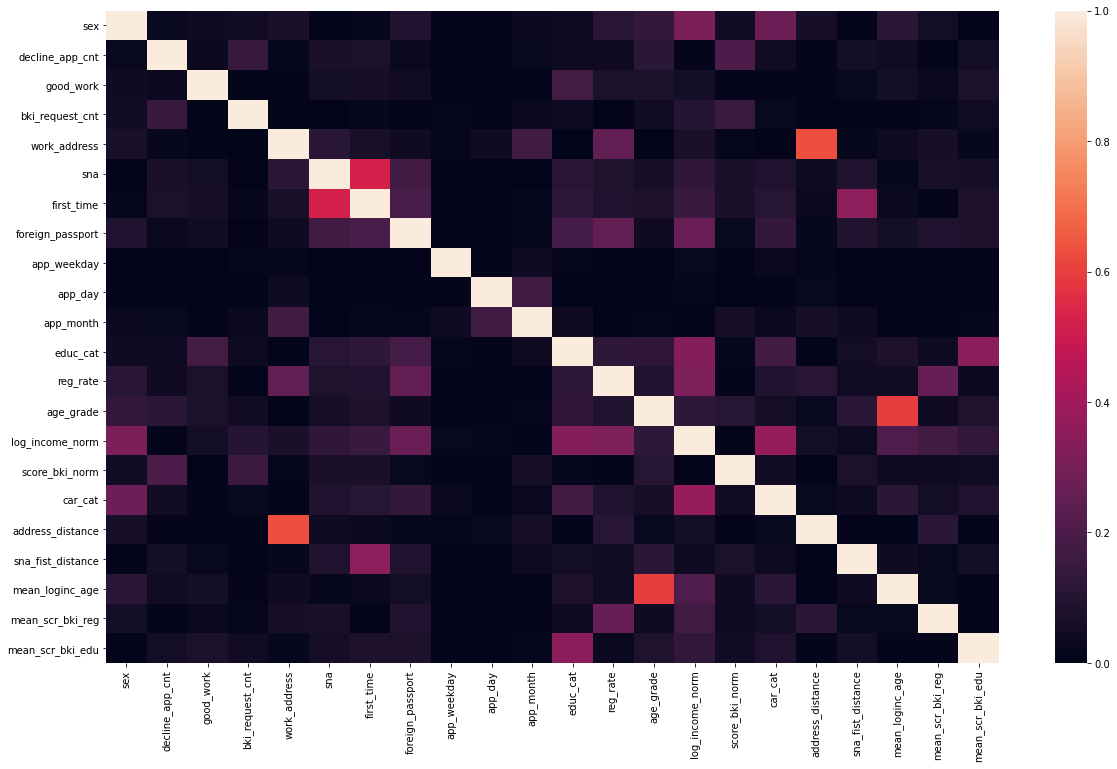

In [103]:
plt.figure(figsize=(20, 12))
sns.heatmap(data[model_cols].corr().abs(), vmin=0, vmax=1, annot = False);

In [104]:
show_high_corr_features(data,model_cols)

Series([], dtype: float64)

Model: LogReg, DecTree, AdaBst, GradBst, done. 196.9128 sec


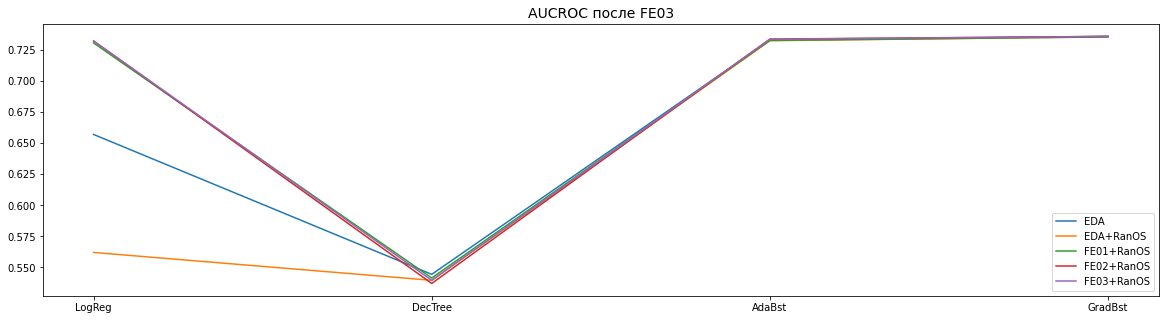

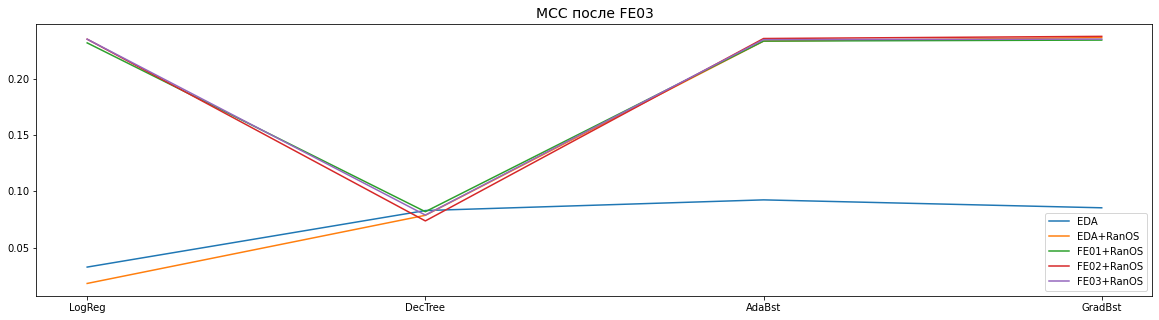

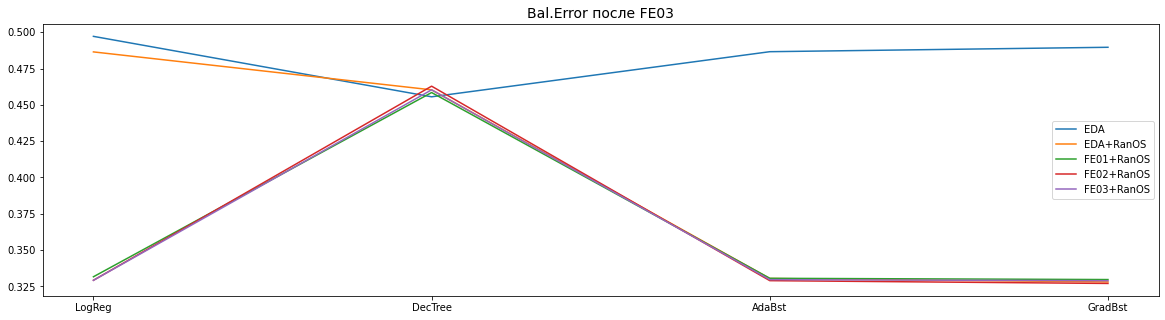

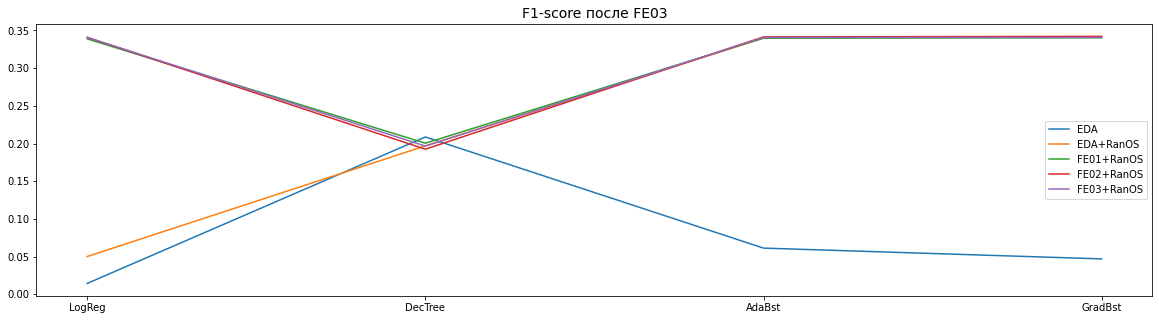

In [105]:
model_cols = model_cols + ['default']
# fe_eval['FE03'] = eval_basic_models(data[model_cols], 'None', short_mod_list )
fe_eval['FE03+RanOS'] = eval_basic_models(data[model_cols], 'RanOS', short_mod_list )
compare_scenarios_plot(fe_eval,'AUCROC','AUCROC после FE03')
compare_scenarios_plot(fe_eval,'MCC','MCC после FE03')
compare_scenarios_plot(fe_eval,'Bal.Error','Bal.Error после FE03')
compare_scenarios_plot(fe_eval,'f1-score','F1-score после FE03')

При анализе графиков я столкнулся с тем, что результаты с дополнением младшего класса сливаются между собой, также и результаты без дополнения. 
Сделаю новую итерацию рабочего блокнота с исключением моделирования без дополнения. 

### FOHE - "взрыв" категориальных признаков

In [106]:
data.columns

Index(['client_id', 'app_date', 'education', 'sex', 'age', 'decline_app_cnt',
       'good_work', 'score_bki', 'bki_request_cnt', 'work_address', 'income',
       'sna', 'first_time', 'foreign_passport', 'default', 'app_weekday',
       'app_day', 'app_month', 'educ_cat', 'reg_rate', 'age_grade',
       'log_income', 'log_income_norm', 'score_bki_norm', 'car_cat',
       'address_distance', 'sna_fist_distance', 'mean_loginc_age',
       'mean_scr_bki_reg', 'mean_scr_bki_edu'],
      dtype='object')

In [107]:
cat_feat = ['education', 'work_address', 'sna', 'first_time', 'reg_rate', 'age_grade', 'car_cat', 'address_distance', 'sna_fist_distance' ]
data = pd.get_dummies(data, prefix=cat_feat, columns=cat_feat)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 59 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   client_id            73799 non-null  int64  
 1   app_date             73799 non-null  object 
 2   sex                  73799 non-null  int64  
 3   age                  73799 non-null  int64  
 4   decline_app_cnt      73799 non-null  int64  
 5   good_work            73799 non-null  int64  
 6   score_bki            73799 non-null  float64
 7   bki_request_cnt      73799 non-null  int64  
 8   income               73799 non-null  int64  
 9   foreign_passport     73799 non-null  int64  
 10  default              73799 non-null  int64  
 11  app_weekday          73799 non-null  int64  
 12  app_day              73799 non-null  int64  
 13  app_month            73799 non-null  int64  
 14  educ_cat             73799 non-null  int64  
 15  log_income           73799 non-null 

In [108]:
data.columns

Index(['client_id', 'app_date', 'sex', 'age', 'decline_app_cnt', 'good_work',
       'score_bki', 'bki_request_cnt', 'income', 'foreign_passport', 'default',
       'app_weekday', 'app_day', 'app_month', 'educ_cat', 'log_income',
       'log_income_norm', 'score_bki_norm', 'mean_loginc_age',
       'mean_scr_bki_reg', 'mean_scr_bki_edu', 'education_ACD',
       'education_GRD', 'education_PGR', 'education_SCH', 'education_UGR',
       'work_address_1', 'work_address_2', 'work_address_3', 'sna_1', 'sna_2',
       'sna_3', 'sna_4', 'first_time_1', 'first_time_2', 'first_time_3',
       'first_time_4', 'reg_rate_2', 'reg_rate_3', 'reg_rate_4', 'reg_rate_5',
       'reg_rate_6', 'reg_rate_7', 'reg_rate_8', 'age_grade_0', 'age_grade_1',
       'age_grade_2', 'age_grade_3', 'age_grade_4', 'car_cat_0', 'car_cat_1',
       'car_cat_2', 'address_distance_0', 'address_distance_1',
       'address_distance_2', 'sna_fist_distance_0', 'sna_fist_distance_1',
       'sna_fist_distance_2', 'sna_fist_d

In [109]:
model_cols = ['sex', 'decline_app_cnt', 'good_work', 'bki_request_cnt', 'foreign_passport', 'app_weekday', 'app_day', 'app_month',
              'log_income_norm', 'score_bki_norm', 'mean_loginc_age', 'mean_scr_bki_reg', 'mean_scr_bki_edu', 'education_ACD', 'education_GRD', 'education_PGR', 'education_SCH', 'education_UGR',  'work_address_1', 'work_address_2', 'work_address_3', 'sna_1', 'sna_2', 'sna_3', 'sna_4', 'first_time_1', 'first_time_2', 'first_time_3', 'first_time_4', 'reg_rate_2', 'reg_rate_3', 'reg_rate_4', 'reg_rate_5', 'reg_rate_6', 'reg_rate_7', 'reg_rate_8', 'age_grade_0', 'age_grade_1', 'age_grade_2', 'age_grade_3', 'age_grade_4', 'car_cat_0', 'car_cat_1', 'car_cat_2', 'address_distance_0', 'address_distance_1', 'address_distance_2', 'sna_fist_distance_0', 'sna_fist_distance_1', 'sna_fist_distance_2', 'sna_fist_distance_3']

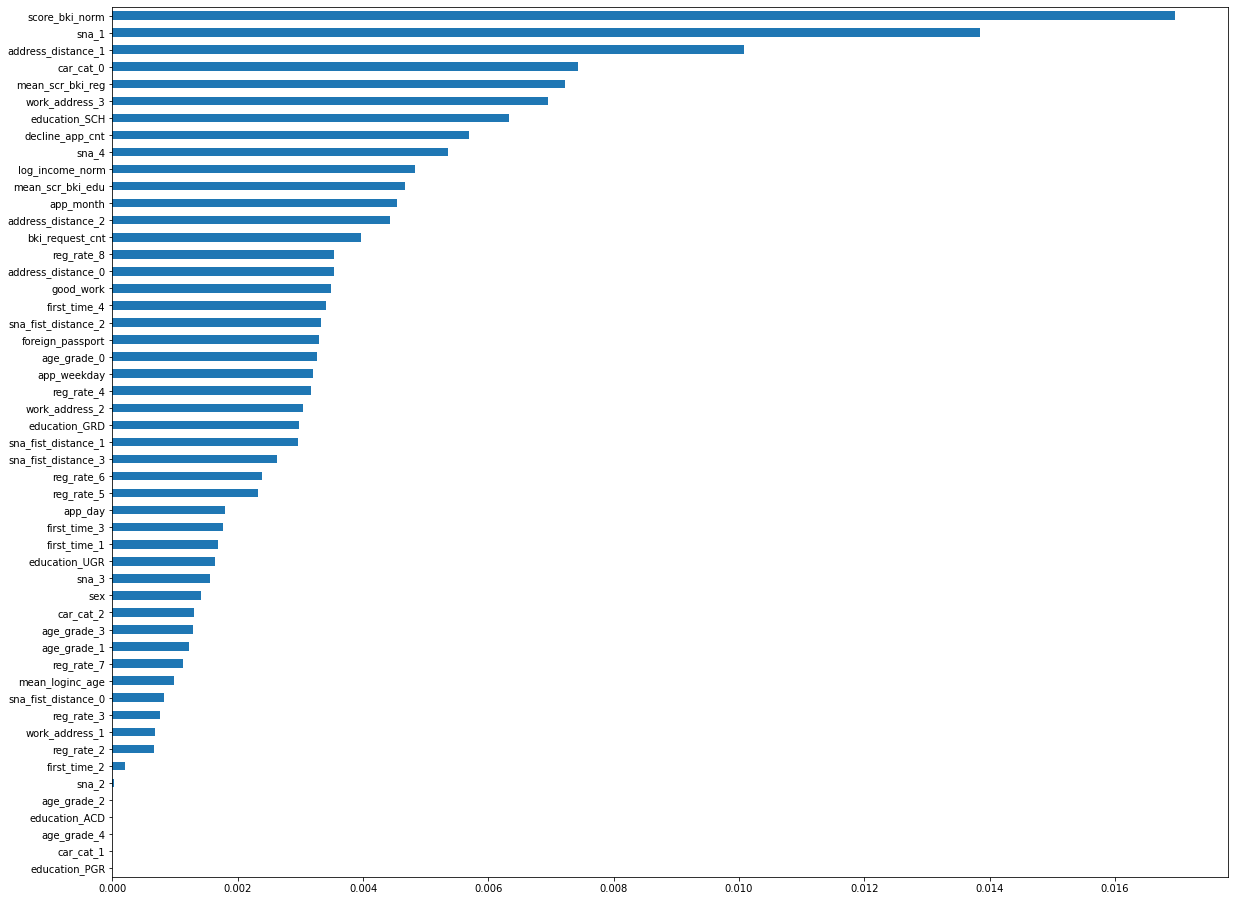

In [110]:
plt.figure(figsize=(20, 16))
imp_cat = Series(mutual_info_classif(data[model_cols], data['default']), index=model_cols)
imp_cat.sort_values(inplace=True)
imp_cat.plot(kind='barh');

In [111]:
unimp_col=show_min_important_features(data,model_cols,'default') ; unimp_col


sna_2            0.0
education_UGR    0.0
education_ACD    0.0
reg_rate_3       0.0
app_weekday      0.0
first_time_2     0.0
education_PGR    0.0
age_grade_4      0.0
dtype: float64

In [112]:
# list3 =  [x for x in list1 if x not in list2] - делает разность двух списков
model_cols = [x for x in model_cols if x not in unimp_col]
model_cols

['sex',
 'decline_app_cnt',
 'good_work',
 'bki_request_cnt',
 'foreign_passport',
 'app_day',
 'app_month',
 'log_income_norm',
 'score_bki_norm',
 'mean_loginc_age',
 'mean_scr_bki_reg',
 'mean_scr_bki_edu',
 'education_GRD',
 'education_SCH',
 'work_address_1',
 'work_address_2',
 'work_address_3',
 'sna_1',
 'sna_3',
 'sna_4',
 'first_time_1',
 'first_time_3',
 'first_time_4',
 'reg_rate_2',
 'reg_rate_4',
 'reg_rate_5',
 'reg_rate_6',
 'reg_rate_7',
 'reg_rate_8',
 'age_grade_0',
 'age_grade_1',
 'age_grade_2',
 'age_grade_3',
 'car_cat_0',
 'car_cat_1',
 'car_cat_2',
 'address_distance_0',
 'address_distance_1',
 'address_distance_2',
 'sna_fist_distance_0',
 'sna_fist_distance_1',
 'sna_fist_distance_2',
 'sna_fist_distance_3']

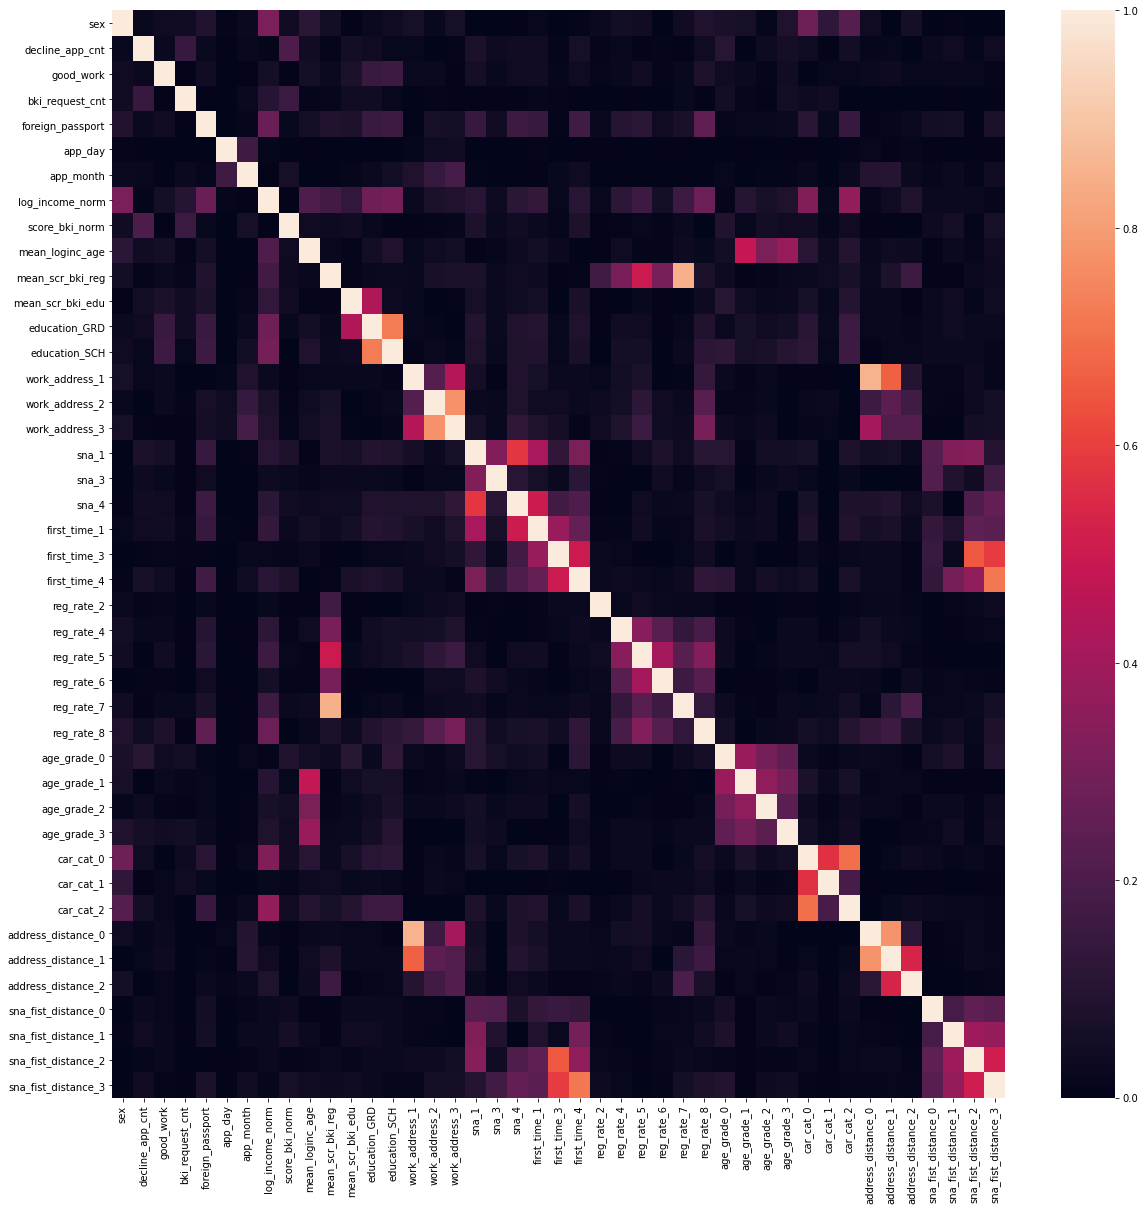

In [113]:
plt.figure(figsize=(20, 20))
sns.heatmap(data[model_cols].corr().abs(), vmin=0, vmax=1, annot = False);

In [114]:
show_high_corr_features(data,model_cols)

work_address_1      address_distance_0    0.851909
address_distance_0  work_address_1        0.851909
mean_scr_bki_reg    reg_rate_7            0.850715
reg_rate_7          mean_scr_bki_reg      0.850715
dtype: float64

In [115]:
high_corr_col = ['address+distance_0', 'reg_rate_7']
model_cols = [x for x in model_cols if x not in high_corr_col]

In [116]:
model_cols = [x for x in model_cols if x not in ['default'] ]

Model: LogReg, DecTree, AdaBst, GradBst, done. 207.0510 sec
Model: LogReg, DecTree, AdaBst, GradBst, done. 408.9168 sec


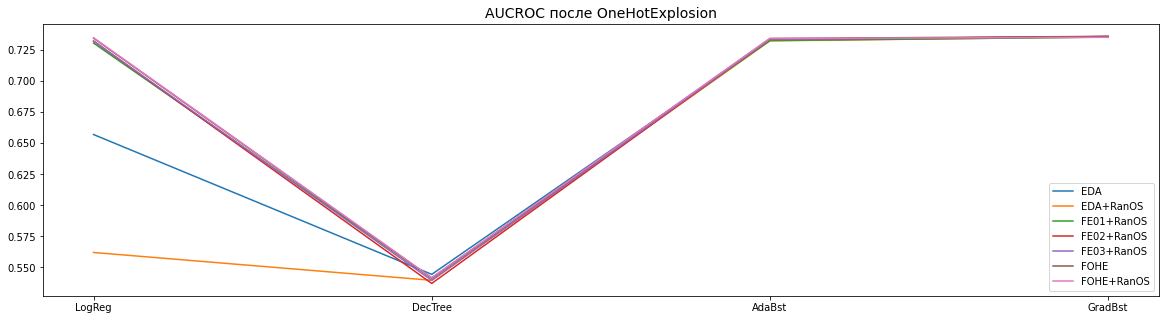

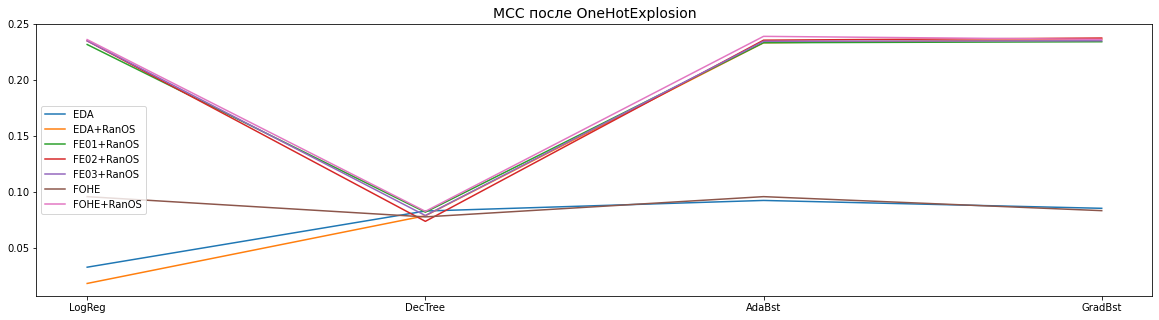

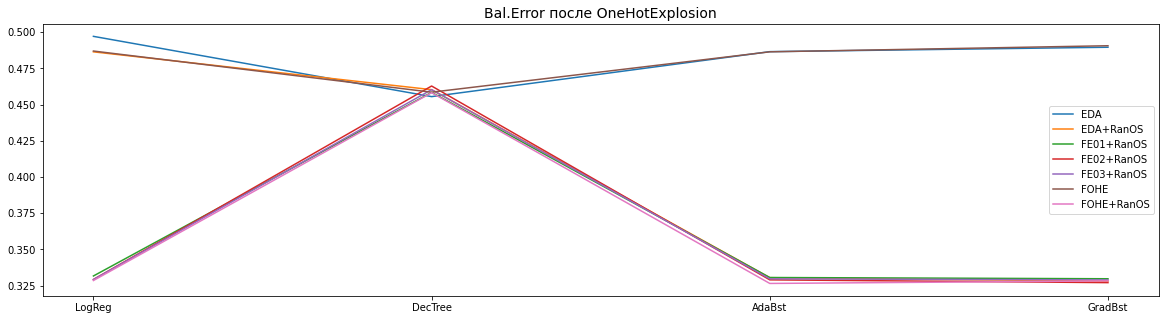

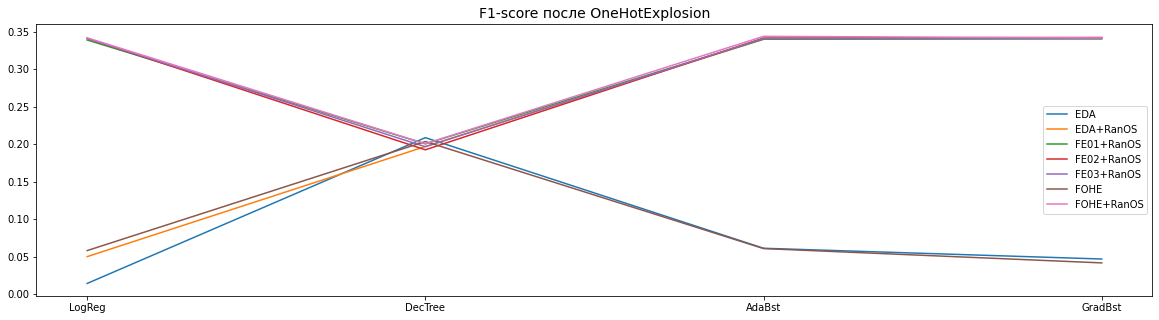

In [117]:
model_cols = model_cols + ['default']
fe_eval['FOHE'] = eval_basic_models(data[model_cols], 'None', short_mod_list )
fe_eval['FOHE+RanOS'] = eval_basic_models(data[model_cols], 'RanOS', short_mod_list )
compare_scenarios_plot(fe_eval,'AUCROC','AUCROC после OneHotExplosion')
compare_scenarios_plot(fe_eval,'MCC','MCC после OneHotExplosion')
compare_scenarios_plot(fe_eval,'Bal.Error','Bal.Error после OneHotExplosion')
compare_scenarios_plot(fe_eval,'f1-score','F1-score после OneHotExplosion')

In [118]:
fe_eval['FOHE+RanOS']

,LogReg,DecTree,AdaBst,GradBst
Recall,0.67102,0.20316,0.67358,0.67328
Selectivity,0.67192,0.88036,0.67334,0.67020
FNR,0.32898,0.79684,0.32642,0.32672
FPR,0.32808,0.11964,0.32666,0.32980
Bal.Error,0.32852,0.45826,0.32650,0.32824
AUCROC,0.73500,0.54174,0.73444,0.73534
f1-score,0.34180,0.20056,0.34372,0.34172
MCC,0.23630,0.08264,0.23918,0.23646


In [119]:
fe_eval['FOHE']

,LogReg,DecTree,AdaBst,GradBst
Recall,0.03094,0.22034,0.03254,0.02176
Selectivity,0.99502,0.86250,0.99450,0.99686
FNR,0.96906,0.77966,0.96746,0.97824
FPR,0.00498,0.13750,0.00550,0.00314
Bal.Error,0.48702,0.45860,0.48648,0.49068
AUCROC,0.73464,0.54140,0.73438,0.73612
f1-score,0.05810,0.20350,0.06078,0.04168
MCC,0.09578,0.07766,0.09578,0.08324


### Промежуточные выводы

Алгоритм логистической регрессии на данном наборе достаточно хорошо смотрелся на фоне сложных ансамблей. Однако с два важных фактора оказали влияние на обучение и качество моделей - несбалансированность данных и целевая метрика. Для обеспечения устоячивости данных на этапе обучения использовалась перекрестная проверка по 5 блокам данных. Учитывая несбалансированность - использовался алгоритм, распределяющий данные по пяти блокам с учетом соблюдения распределение данных в блоках и общей рабочей выборке по целевой переменной. После разделения обучающий набор случайным образом дополнялся до равновесного распределения итоговых значений.

В предложенном наборе данных дефолтных заемщиков намного меньше чем хороших. Поэтому в отсутствие дополнения обучающего набора до балансирования модель достигла хороших показателей по предложенной метрике AUCROC, однако имеет слишком высокий FNR - отсев дефолтных заемщиков будет плохим и банк будет терять на выданных займах.  Интересно что самая слабая модель по AUCROC Решающее Дерево лучше адаптировалась к неравновесности набора и имеет меньший сред прочих коэффициент FNR.

Если же дополнять набор случайным образом на этапе обучения до сбалансированного - то картина меняется.  Ансамблевые алгоритмы Логистическая регрессия показывают сопоставимые характеристики по AUCROC но отличаются значительно подросшим f1-score и меньшими значениями ошибок I и II рода: которые составляют уже примерно по 1/3.

Показатель f1-score хорошо учитывает несбалансированность выборки. В отсутствие иных показателей (например при стандартном конвейере scikit-learn) этот показатель может использоваться для выбора оптимальной модели. Но показатели ошибок I и II рода лучше рассчитывать.

Следующая стадия отработки модели - подбор гиперпараметров. Представляется важным продолжить практику обучения модели с использованием случайного дополнения обучающей выборки до баланса.  Предстоит выяснить наличие готовых узлов конвейера и запрограммировать поиск гиперпараметра.  Подбор гиперпараметров будет осуществлен для базового алгоритма Логистической регрессии и возможно для одного из двух ансамблевых алгоритмов.   

## Тестирование пороговой гипотезы

В ходе поиска и изучения решений по несбалансированным данным мне попалось интересное утверждение.  Несбалансированность данных может иметь меньшее значение в ML чем хорошие данные и модель с правильными гиперпараметрами. Если aucroc кривая достаточно выпуклая и площадь под ней хорошая, то регулировкой порога можно подобрать положение, отвечающее требованиям по отсеву ошибок I и II рода.  В банковских кругах могут предпочесть разумный минимум (0…0.05) FNR, то есть предпочтут отказать не очень хорошему заемщику с тем, чтобы не терять выданный плохому заемщику кредит.

Попробую проверить это утверждение на практике. Для этого модель LogisticRegression проведет 5 циклов обучения со сбалансированной кроссвалидацией но без случайного дополнения выборки данных. Получим пять наборов предсказаний до срабатывания порога. Дальше построим метрики при разных значениях порога и попробуем найти оптимальные значения этих метрик.

In [120]:
prob_data = calc_probs(data[model_cols])
print('Min {:.4f}'.format(prob_data['y_prob'].min()), 'Max {:.4f}'.format(prob_data['y_prob'].max()))

01234 done. 107.4852 sec
Min 0.0037 Max 0.8625


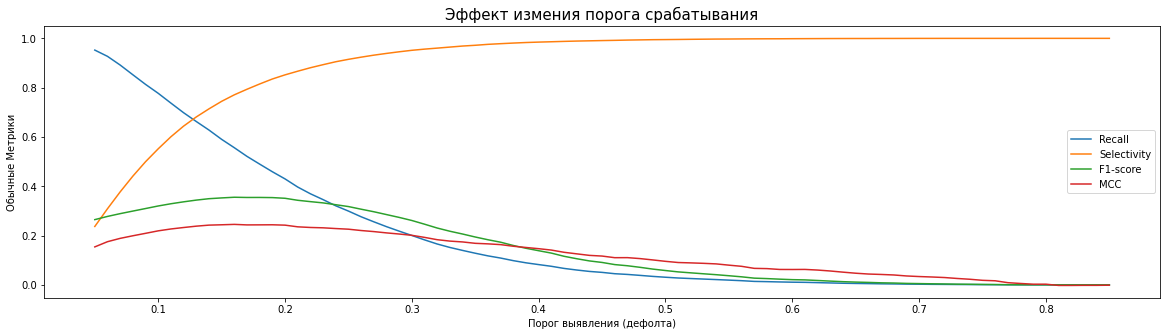

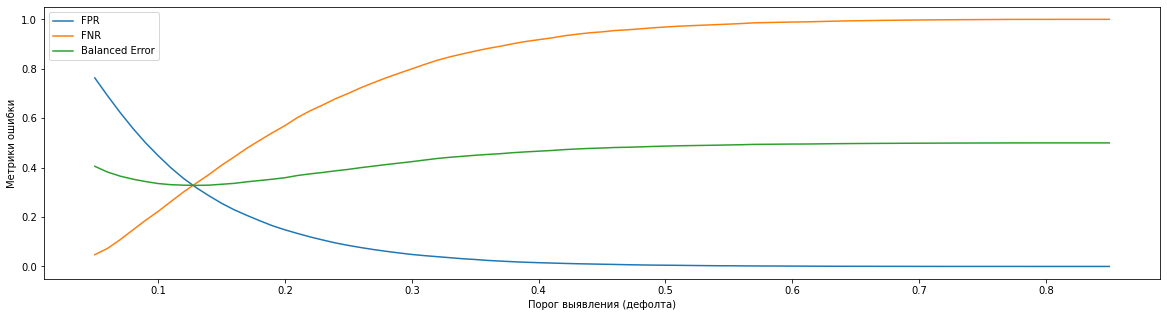

In [121]:
review = calc_metrics(prob_data)
plt.figure(figsize=(20, 5))
plt.title('Эффект измения порога срабатывания', fontsize=15)
plt.plot(review.lvl, review.Recall, label='Recall')
plt.plot(review.lvl, review.Selectivity, label='Selectivity')
plt.plot(review.lvl, review['f1-score'], label='F1-score')
plt.plot(review.lvl, review.MCC, label='MCC')
plt.xlabel('Порог выявления (дефолта)')
plt.ylabel('Обычные Метрики')
plt.legend(loc = 'best');
plt.figure(figsize=(20, 5))
# plt.title('Эффект измения порога срабатывания', fontsize=15)
plt.plot(review.lvl, review.FPR, label='FPR')
plt.plot(review.lvl, review.FNR, label='FNR')
plt.plot(review.lvl, review['Bal.Error'], label='Balanced Error')
plt.xlabel('Порог выявления (дефолта)')
plt.ylabel('Метрики ошибки')
plt.legend(loc = 'best');


А что будет в случае балансировки обучающей выборки случайным образом?

In [122]:
prob_osdata = calc_probs(data[model_cols],oversample=True)
print('Min {:.4f}'.format(prob_osdata['y_prob'].min()), 'Max {:.4f}'.format(prob_osdata['y_prob'].max()))

01234 done. 193.0190 sec
Min 0.0225 Max 0.9819


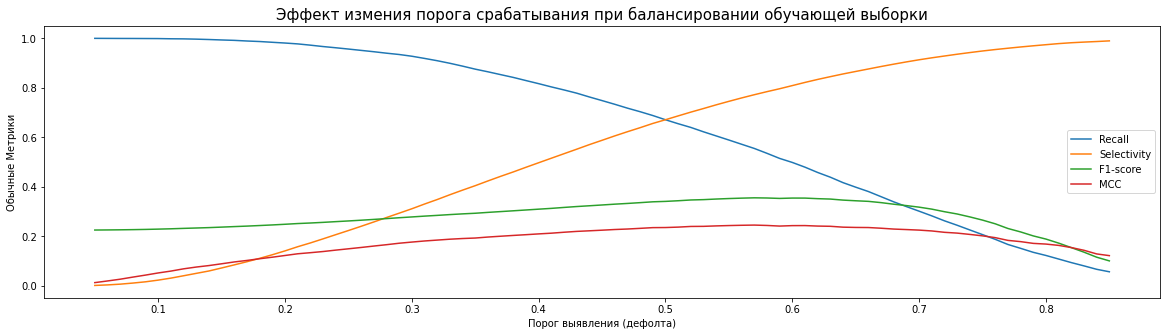

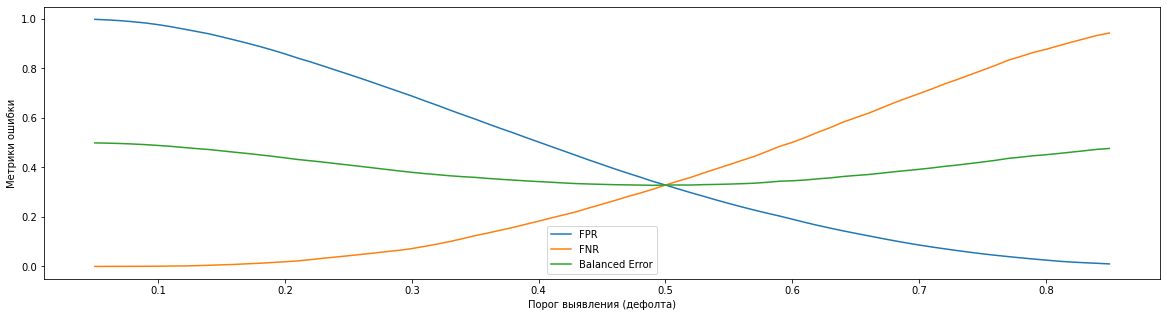

In [123]:
osreview = calc_metrics(prob_osdata)
plt.figure(figsize=(20, 5))
plt.title('Эффект измения порога срабатывания при балансировании обучающей выборки', fontsize=15)
plt.plot(review.lvl, osreview.Recall, label='Recall')
plt.plot(review.lvl, osreview.Selectivity, label='Selectivity')
plt.plot(review.lvl, osreview['f1-score'], label='F1-score')
plt.plot(review.lvl, osreview.MCC, label='MCC')
plt.xlabel('Порог выявления (дефолта)')
plt.ylabel('Обычные Метрики')
plt.legend(loc='best');
plt.figure(figsize=(20, 5))
# plt.title('Эффект измения порога срабатывания', fontsize=15)
plt.plot(review.lvl, osreview.FPR, label='FPR')
plt.plot(review.lvl, osreview.FNR, label='FNR')
plt.plot(review.lvl, osreview['Bal.Error'], label='Balanced Error')
plt.xlabel('Порог выявления (дефолта)')
plt.ylabel('Метрики ошибки')
plt.legend(loc='best');


Вывод:  Утверждение об отсутствии влияния обеспечения сбалансированности выборки не подтвердилось.  Балансировка обучающей выборки позволяет обеспечить лучшую пологость кривых качества и ошибок моделей, а также и возможность более точной установки порога.  Например, определение низкого порога FNR пожет не сложиться при обучении на несбалансированных данных.

Однако учебная задача поставлена по обеспечению максимума AUCROC. В этой связи предполагаю что подбор гиперпараметров можно осуществить и на обычной моедли. При необходимости всегда можно переобучить модель с выбранными параметрами на дополнительно сбалансированных учебных выборках.

(Продолжение в третьей рабочей книге.)